In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

### Loading results of Behaviour Space

Data can be downloaded from this folder: https://drive.google.com/drive/folders/1Z-0xZ2d7uZQC_mTyIv5WrFKSS-VN8Bgb and later saved to the same local folder where this notebook is saved.

In [2]:
ss3 = pd.read_csv('ss3_wealth_distribution.csv', skiprows=6)
ss3.head()

,[run number],increase,minimum-sugar-endowment,initial-population,[step],(gini-index-reserve / count turtles) * 2,(sugar-histogram)
0,16,10,10,10,0,0.019626,[0 0 0 0 0 0 0 0 3 7]
1,12,10,10,10,0,0.023810,[0 0 0 0 0 0 0 0 5 5]
2,14,10,10,10,0,0.022642,[0 0 0 0 0 0 0 0 4 6]
3,2,10,10,10,0,0.023810,[0 0 0 0 0 0 0 0 5 5]
4,15,10,10,10,0,0.022642,[0 0 0 0 0 0 0 0 4 6]


### Obtaining basic data of the Behaviour Space results

In [3]:
row_count = ss3.shape[0]
print("Number of rows in ss3:", row_count)

Number of rows in ss3: 5401800


In [4]:
print("Name of columns:", ss3.columns.tolist())

Name of columns: ['[run number]', 'increase', 'minimum-sugar-endowment', 'initial-population', '[step]', '(gini-index-reserve / count turtles) * 2', '(sugar-histogram)']


### Preprocessing data

In [ ]:
#Rename columns

ss3.rename(columns={
    '[run number]': 'run',
    'increase': 'increase',
    'minimum-sugar-endowment': 'min_init_sugar',
    'initial-population': 'init_pop',
    '[step]': 'step',
    '(gini-index-reserve / count turtles) * 2': 'gini_index',
    '(sugar-histogram)': 'sugar_histogram',
}, inplace=True)

ss3.head()

,run,increase,min_init_sugar,init_pop,step,gini_index,sugar_histogram
0,16,10,10,10,0,0.019626,[0 0 0 0 0 0 0 0 3 7]
1,12,10,10,10,0,0.023810,[0 0 0 0 0 0 0 0 5 5]
2,14,10,10,10,0,0.022642,[0 0 0 0 0 0 0 0 4 6]
3,2,10,10,10,0,0.023810,[0 0 0 0 0 0 0 0 5 5]
4,15,10,10,10,0,0.022642,[0 0 0 0 0 0 0 0 4 6]


In [6]:
unique_increase = ss3['increase'].unique()
unique_minimum_sugar = ss3['min_init_sugar'].unique()
unique_initial_population = ss3['init_pop'].unique()


print("Unique values in 'increase':", unique_increase)
print("Unique values in 'minimum-sugar-endowment':", unique_minimum_sugar)
print("Unique values in 'initial-population':", unique_initial_population)

Unique values in 'increase': [ 10  50 100]
Unique values in 'minimum-sugar-endowment': [ 10  50 100]
Unique values in 'initial-population': [ 10 110 210 310 410 510 610 710 810 910]


In [7]:
#convert sugar_histogram to numpy array and integers
ss3["sugar_histogram"] = ss3["sugar_histogram"].apply(lambda x: np.array(list(map(int, x.strip("[]").split())), dtype=int))
ss3.head()

,run,increase,min_init_sugar,init_pop,step,gini_index,sugar_histogram
0,16,10,10,10,0,0.019626,"[0, 0, 0, 0, 0, 0, 0, 0, 3, 7]"
1,12,10,10,10,0,0.023810,"[0, 0, 0, 0, 0, 0, 0, 0, 5, 5]"
2,14,10,10,10,0,0.022642,"[0, 0, 0, 0, 0, 0, 0, 0, 4, 6]"
3,2,10,10,10,0,0.023810,"[0, 0, 0, 0, 0, 0, 0, 0, 5, 5]"
4,15,10,10,10,0,0.022642,"[0, 0, 0, 0, 0, 0, 0, 0, 4, 6]"


I decided to do 20 repetitions in order to account for different variances that could happen on a single repetition. But in order to analyse the outcomes of the model, I will use the average value of this 20 repetitions

In [8]:
#Group by all vary variables
ss3_grouped = ss3.groupby(['increase', 'min_init_sugar', 'init_pop', 'step']).mean().reset_index()
ss3_grouped.drop(columns=['run'], inplace=True)
ss3_grouped.head()

,increase,min_init_sugar,init_pop,step,gini_index,sugar_histogram
0,10,10,10,0,0.021935,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.1, ..."
1,10,10,10,1,0.073812,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.55, 3.25, 2.35, 2...."
2,10,10,10,2,0.144839,"[0.0, 0.0, 0.25, 0.65, 1.35, 1.9, 1.6, 1.55, 1..."
3,10,10,10,3,0.216091,"[0.25, 0.35, 0.8, 1.2, 1.45, 1.2, 1.25, 1.35, ..."
4,10,10,10,4,0.243430,"[0.25, 0.65, 1.15, 1.35, 1.1, 1.5, 0.65, 1.75,..."


In [9]:
#check that the amount of rows has reduced 20 times
ss3_grouped.shape[0]==row_count/20

True

I decided to add as a reporter the amount of turtles by bin in a histogram of wealth distribution. In order to be able to compare them, I'll convert this values to percentages, adding up to 100% of turtles.

In [10]:
#Modify sugar_histogram values from float to percentage and round to 2 decimal places
ss3_grouped['sugar_histogram'] = ss3_grouped['sugar_histogram'].apply(lambda x: np.round((np.array(x) / np.sum(x)) * 100, 2))
ss3_grouped.head()

,increase,min_init_sugar,init_pop,step,gini_index,sugar_histogram
0,10,10,10,0,0.021935,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0,..."
1,10,10,10,1,0.073812,"[0.0, 0.0, 0.0, 0.0, 0.0, 5.5, 32.5, 23.5, 23...."
2,10,10,10,2,0.144839,"[0.0, 0.0, 2.5, 6.5, 13.5, 19.0, 16.0, 15.5, 1..."
3,10,10,10,3,0.216091,"[2.5, 3.5, 8.0, 12.0, 14.5, 12.0, 12.5, 13.5, ..."
4,10,10,10,4,0.243430,"[2.5, 6.5, 11.5, 13.5, 11.0, 15.0, 6.5, 17.5, ..."


In order to do multiple types of analysis, I have created distinct dataframes grouping by different columns

In [11]:
#Group by initial population and get the last value of each group. This will ignore values of step and give me only one row per initial population
ss3_grouped_initpop = ss3_grouped.groupby('init_pop').last().reset_index()
ss3_grouped_initpop.head()

,init_pop,increase,min_init_sugar,step,gini_index,sugar_histogram
0,10,100,100,3000,0.206163,"[1.5, 3.0, 4.5, 14.5, 15.5, 18.0, 13.0, 7.0, 9..."
1,110,100,100,3000,0.231152,"[2.0, 5.36, 13.73, 23.59, 22.45, 14.05, 8.73, ..."
2,210,100,100,3000,0.228160,"[2.29, 5.4, 12.45, 22.17, 21.81, 16.98, 8.76, ..."
3,310,100,100,3000,0.238419,"[3.16, 6.9, 15.0, 23.11, 22.03, 14.9, 7.65, 4...."
4,410,100,100,3000,0.236204,"[3.32, 6.98, 12.89, 22.06, 21.44, 17.05, 8.74,..."


In [12]:
# Group by step and initial population, then calculate mean values
ss3_grouped_step_initpop = ss3_grouped.groupby(['step', 'init_pop']).mean().reset_index()
ss3_grouped_step_initpop.head()

,step,init_pop,increase,min_init_sugar,gini_index,sugar_histogram
0,0,10,53.333333,53.333333,0.063553,"[0.0, 0.0, 0.0, 0.0, 0.7777777777777778, 5.5, ..."
1,0,110,53.333333,53.333333,0.069090,"[0.0, 0.0, 0.0, 0.0, 1.2377777777777779, 6.545..."
2,0,210,53.333333,53.333333,0.069433,"[0.0, 0.0, 0.0, 0.0, 1.3755555555555554, 6.436..."
3,0,310,53.333333,53.333333,0.069579,"[0.0, 0.0, 0.0, 0.0, 1.2844444444444445, 6.565..."
4,0,410,53.333333,53.333333,0.069517,"[0.0, 0.0, 0.0, 0.0, 1.4255555555555555, 6.382..."


In [13]:
#Group by step and calculate mean values. This will ignore values of initial population and give me only one row per step
ss3_grouped_step = ss3_grouped.groupby('step').mean().reset_index()
ss3_grouped_step.head()

,step,increase,min_init_sugar,init_pop,gini_index,sugar_histogram
0,0,53.333333,53.333333,460.0,0.068854,"[0.0, 0.0, 0.0, 0.0, 1.294888888888889, 6.3352..."
1,1,53.333333,53.333333,460.0,0.081823,"[0.0, 0.0, 0.06322222222222222, 0.727333333333..."
2,2,53.333333,53.333333,460.0,0.104225,"[0.03977777777777777, 0.424, 1.663000000000000..."
3,3,53.333333,53.333333,460.0,0.126243,"[0.7827777777777777, 1.4986666666666666, 3.131..."
4,4,53.333333,53.333333,460.0,0.140987,"[1.361222222222222, 2.340222222222223, 4.29244..."


In [14]:
#Extract sugar_histogram values (they represent the mean values by step ignoring initial population) and turn them into columns of a new dataframe
time_histogram = pd.DataFrame(ss3_grouped_step['sugar_histogram'].values.tolist(), index=ss3_grouped_step["step"])
time_histogram.head()

,0,1,2,3,4,5,6,7,8,9
step,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,1.294889,6.335222,13.109778,14.351556,26.289889,38.619111
1,0.000000,0.000000,0.063222,0.727333,3.424667,10.678556,18.282778,18.782333,25.273444,22.767778
2,0.039778,0.424000,1.663000,3.500111,6.077111,13.111778,15.601889,18.497444,25.546000,15.538889
3,0.782778,1.498667,3.131444,5.061889,7.013000,11.232889,16.150000,18.927000,24.052000,12.150222
4,1.361222,2.340222,4.292444,4.720556,7.622444,11.658778,16.253556,19.909556,21.549556,10.290889


In [15]:
#Group by increase and get the mean value of each group. This will ignore values of initial population and give me one row per increase in each step
ss3_avg_gini_increase = ss3_grouped.groupby(['increase', 'step']).mean().reset_index()
ss3_avg_gini_increase.head()

,increase,step,min_init_sugar,init_pop,gini_index,sugar_histogram
0,10,0,53.333333,460.0,0.021150,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.75..."
1,10,1,53.333333,460.0,0.045028,"[0.0, 0.0, 0.0, 0.0, 1.2746666666666664, 2.924..."
2,10,2,53.333333,460.0,0.078851,"[0.0, 0.4703333333333334, 1.6816666666666669, ..."
3,10,3,53.333333,460.0,0.108280,"[1.3596666666666664, 1.7853333333333332, 3.021..."
4,10,4,53.333333,460.0,0.124935,"[1.8143333333333334, 2.6189999999999998, 4.723..."


In [16]:
#Group by increase and initial population. This will ignore values of steps and give me one row per increase in each initial population
ss3_grouped_initpop_increase = ss3_grouped.groupby(['increase', 'init_pop']).mean().reset_index()
ss3_grouped_initpop_increase.head()

,increase,init_pop,min_init_sugar,step,gini_index,sugar_histogram
0,10,10,53.333333,1500.0,0.337871,"[12.41669443518827, 9.817338664889482, 13.1485..."
1,10,110,53.333333,1500.0,0.369755,"[16.55482839053653, 17.96433744307461, 18.6126..."
2,10,210,53.333333,1500.0,0.371717,"[18.65622903476612, 16.30455736976557, 18.7110..."
3,10,310,53.333333,1500.0,0.373911,"[19.95498833722114, 14.374350771964915, 19.411..."
4,10,410,53.333333,1500.0,0.366240,"[18.571936021326234, 15.497605242696885, 19.06..."


In [45]:
#Group by minimum initial sugar and initial population. This will ignore values of steps and give me one row per min_init_sugar in each initial population
ss3_grouped_initpop_minsugar = ss3_grouped.groupby(['min_init_sugar', 'init_pop']).mean().reset_index()
ss3_grouped_initpop_minsugar.head()

,min_init_sugar,init_pop,increase,step,gini_index,sugar_histogram
0,10,10,53.333333,1500.0,0.457312,"[28.94474064200822, 14.190436521159613, 10.410..."
1,10,110,53.333333,1500.0,0.483420,"[35.4570620904144, 18.478843718760377, 13.4522..."
2,10,210,53.333333,1500.0,0.484049,"[38.1734521826058, 18.847232033766524, 11.5350..."
3,10,310,53.333333,1500.0,0.495661,"[42.237821837165455, 15.217575252693598, 11.90..."
4,10,410,53.333333,1500.0,0.479398,"[37.21767299788962, 18.35118182827937, 13.8368..."


### Data analysis

#### Gini index analysis

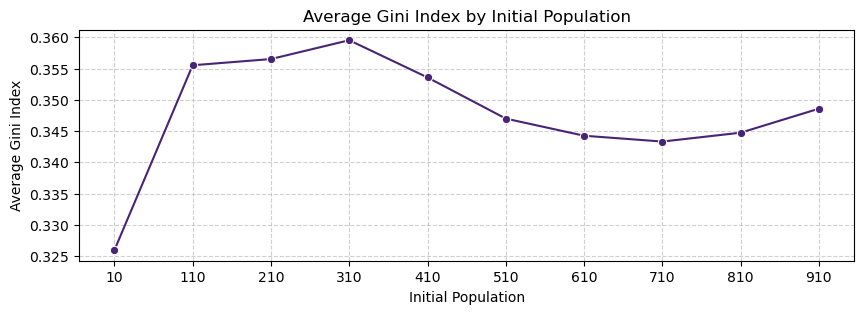

In [41]:
#Graph of average gini index by initial population
gini_avg_per_pop = ss3_grouped_step_initpop.groupby('init_pop')['gini_index'].mean().reset_index()

color = cm.viridis(0.1)  

#Plot line graphic
plt.figure(figsize=(10, 3))
sns.lineplot(x='init_pop', y='gini_index', data=gini_avg_per_pop, marker='o', color=color)

plt.xlabel('Initial Population')
plt.ylabel('Average Gini Index')
plt.title('Average Gini Index by Initial Population')
plt.xticks(np.arange(10, 911, 100)) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

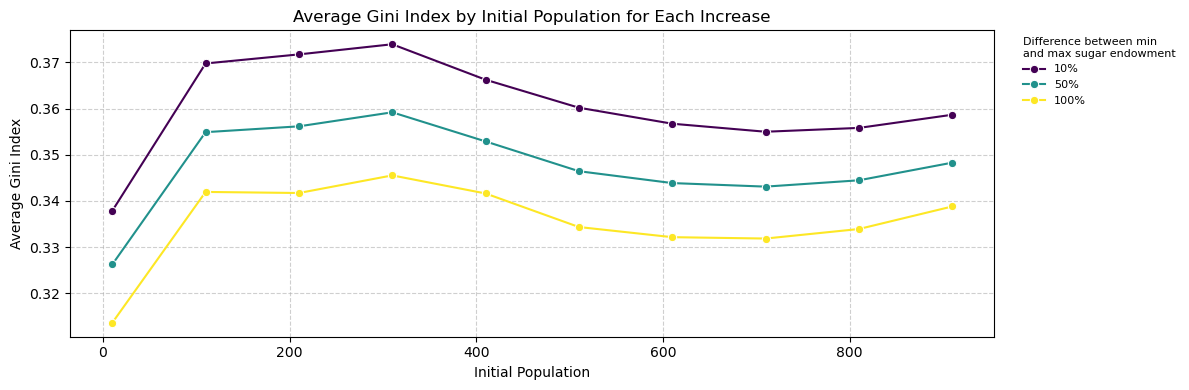

In [39]:
# Graph of average gini index by initial population and increase
plt.figure(figsize=(12, 4))

# Generate colors from the 'viridis' palette
colors = cm.viridis(np.linspace(0, 1, len(unique_increase)))

# Plot each increase as a line
for i, increase in enumerate(unique_increase):
    subset = ss3_grouped_initpop_increase[ss3_grouped_initpop_increase['increase'] == increase]
    gini_avg_per_pop = subset.groupby('init_pop')['gini_index'].mean().reset_index()
    sns.lineplot(x='init_pop', y='gini_index', data=gini_avg_per_pop, marker='o', color=colors[i], label=f'{increase}%')

plt.xlabel('Initial Population')
plt.ylabel('Average Gini Index')
plt.title('Average Gini Index by Initial Population for Each Increase')
plt.legend(title='Difference between min \nand max sugar endowment', bbox_to_anchor=(1.02, 1.01), loc='upper left', frameon=False, title_fontsize=8, fontsize=8, alignment='left')
plt.grid(True, linestyle='--', alpha=0.6)  # Dotted grid lines
plt.tight_layout()
plt.show()

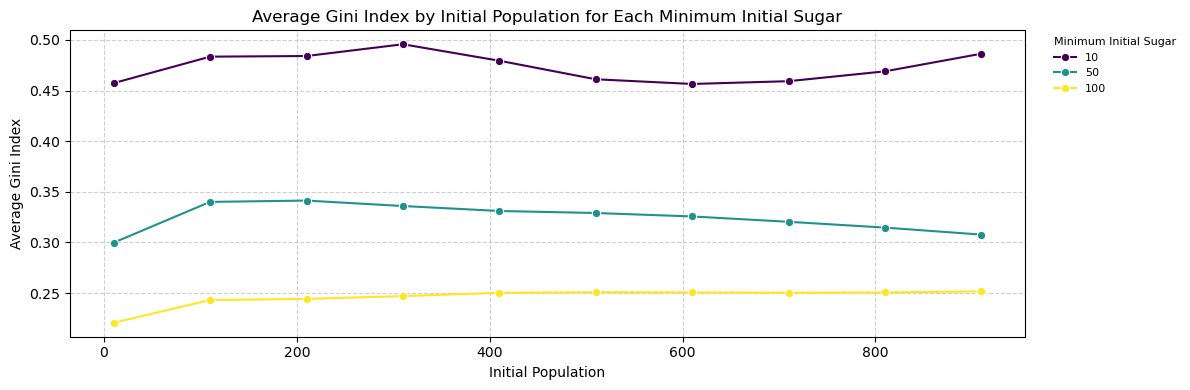

In [47]:
plt.figure(figsize=(12, 4))

# Generate colors from the 'viridis' palette
colors = cm.viridis(np.linspace(0, 1, len(unique_minimum_sugar)))

# Plot each minimum initial sugar as a line
for i, min_sugar in enumerate(unique_minimum_sugar):
    subset = ss3_grouped_initpop_minsugar[ss3_grouped_initpop_minsugar['min_init_sugar'] == min_sugar]
    gini_avg_per_pop = subset.groupby('init_pop')['gini_index'].mean().reset_index()
    sns.lineplot(x='init_pop', y='gini_index', data=gini_avg_per_pop, marker='o', color=colors[i], label=f'{min_sugar}')

plt.xlabel('Initial Population')
plt.ylabel('Average Gini Index')
plt.title('Average Gini Index by Initial Population for Each Minimum Initial Sugar')
plt.legend(title='Minimum Initial Sugar', bbox_to_anchor=(1.02, 1.01), loc='upper left', frameon=False, title_fontsize=8, fontsize=8, alignment='left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

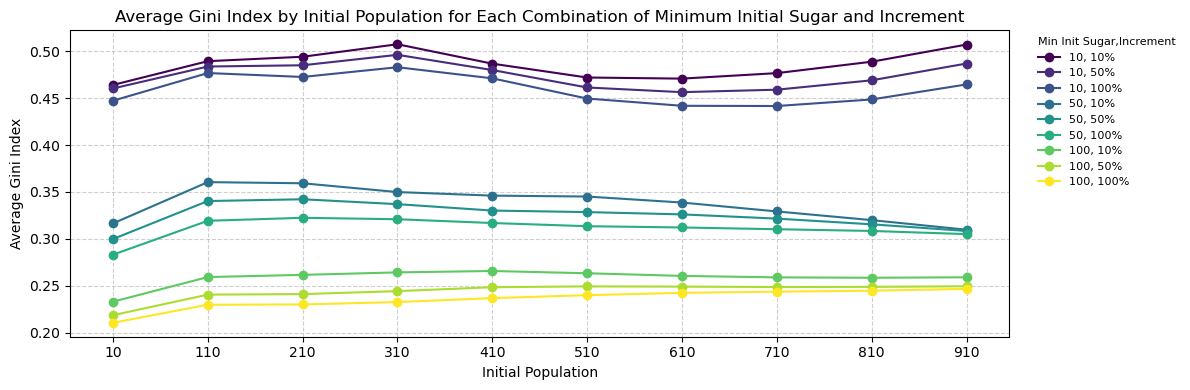

In [77]:
plt.figure(figsize=(12, 4))

# Generate colors from the 'viridis' palette
colors = cm.viridis(np.linspace(0, 1, len(unique_minimum_sugar) * len(unique_increase)))

# Plot each combination of minimum initial sugar and increase
for idx, (min_sugar, increase) in enumerate([(ms, inc) for ms in unique_minimum_sugar for inc in unique_increase]):
    if (min_sugar, increase) in gini_avg_comb_pivot.columns:
        plt.plot(gini_avg_comb_pivot.index, gini_avg_comb_pivot[(min_sugar, increase)], 
                 marker='o', label=f'{min_sugar}, {increase}%', color=colors[idx])

plt.xlabel('Initial Population')
plt.ylabel('Average Gini Index')
plt.title('Average Gini Index by Initial Population for Each Combination of Minimum Initial Sugar and Increment')
plt.xticks(np.arange(10, 911, 100))

# Create the legend as a two-column table
legend_labels = [f'{min_sugar}, {increase}%' for min_sugar in unique_minimum_sugar for increase in unique_increase]
legend_table = plt.legend(title='', labels=legend_labels, bbox_to_anchor=(1.02, 1.01), loc='upper left', frameon=False, fontsize=8, alignment='left')
legend_table.set_title('Min Init Sugar,Increment', prop={'size': 8})

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Now, I'll analyse the evolution of the gini index over time comparing the values obtained depending on the initial population

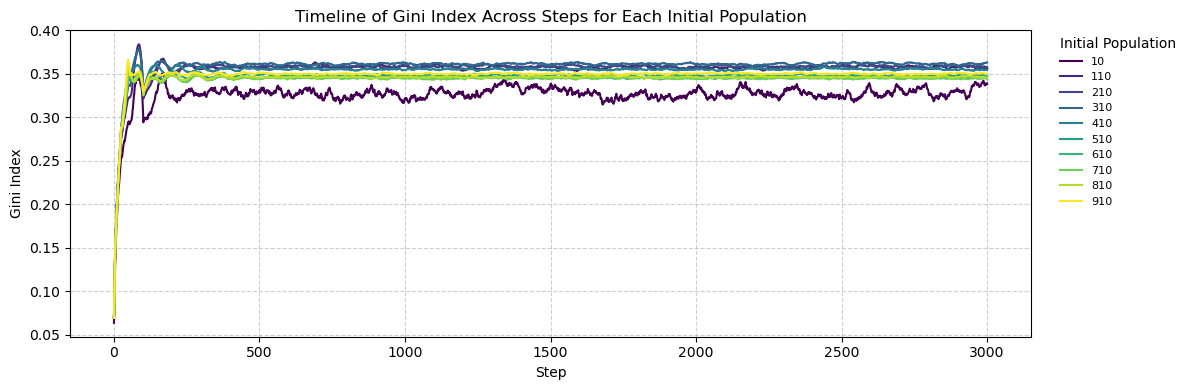

In [32]:
plt.figure(figsize=(12, 4))

# Plot each initial population as a line
colors = cm.viridis(np.linspace(0, 1, len(unique_initial_population)))
for i, population in enumerate(unique_initial_population):
    subset = ss3_grouped_step_initpop[ss3_grouped_step_initpop['init_pop'] == population]
    plt.plot(subset['step'], subset['gini_index'], label=f'{population}', color=colors[i])

plt.xlabel('Step')
plt.ylabel('Gini Index')
plt.title('Timeline of Gini Index Across Steps for Each Initial Population')
plt.legend(title='Initial Population', bbox_to_anchor=(1.02, 1.01), loc='upper left', frameon=False, title_fontsize=10, fontsize=8, alignment='left')
plt.grid(True, linestyle='--', alpha=0.6)  # Dotted grid lines
plt.tight_layout()
plt.show()

We can see that over time, values tend to stabilize, but let's zoom in to the first steps to be able to assess the changes

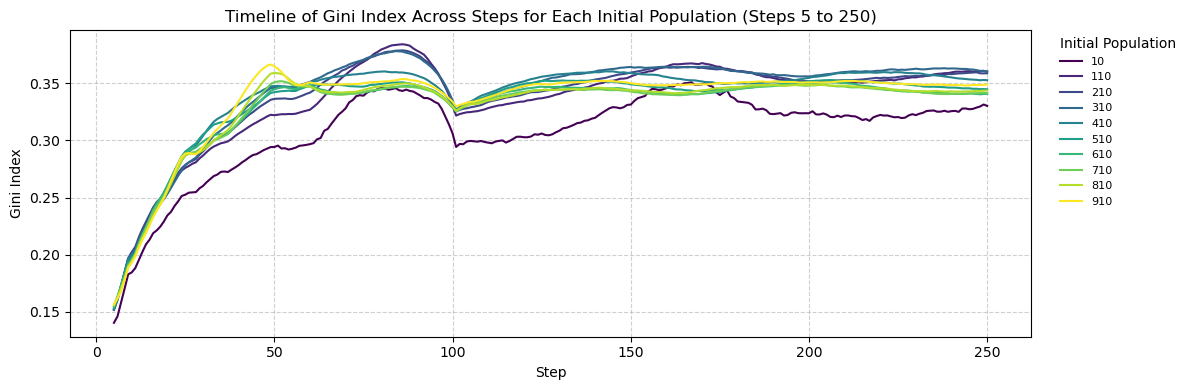

In [30]:
plt.figure(figsize=(12, 4))

# Filter data for steps greater than 5 and less than or equal to 250
ss3_grouped_filtered = ss3_grouped_step_initpop[(ss3_grouped_step_initpop['step'] >= 5) & (ss3_grouped_step_initpop['step'] <= 250)]

# Plot each initial population as a line
colors = cm.viridis(np.linspace(0, 1, len(unique_initial_population)))
for i, population in enumerate(unique_initial_population):
    subset = ss3_grouped_filtered[ss3_grouped_filtered['init_pop'] == population]
    plt.plot(subset['step'], subset['gini_index'], label=f'{population}', color=colors[i])

plt.xlabel('Step')
plt.ylabel('Gini Index')
plt.title('Timeline of Gini Index Across Steps for Each Initial Population (Steps 5 to 250)')
plt.legend(title='Initial Population', bbox_to_anchor=(1.02, 1.01), loc='upper left', frameon=False, title_fontsize=10, fontsize=8, alignment='left')
plt.grid(True, linestyle='--', alpha=0.6)  # Dotted grid lines
plt.tight_layout()
plt.show()

more increase means a larger difference from the start

#### Wealth distribution by initial population

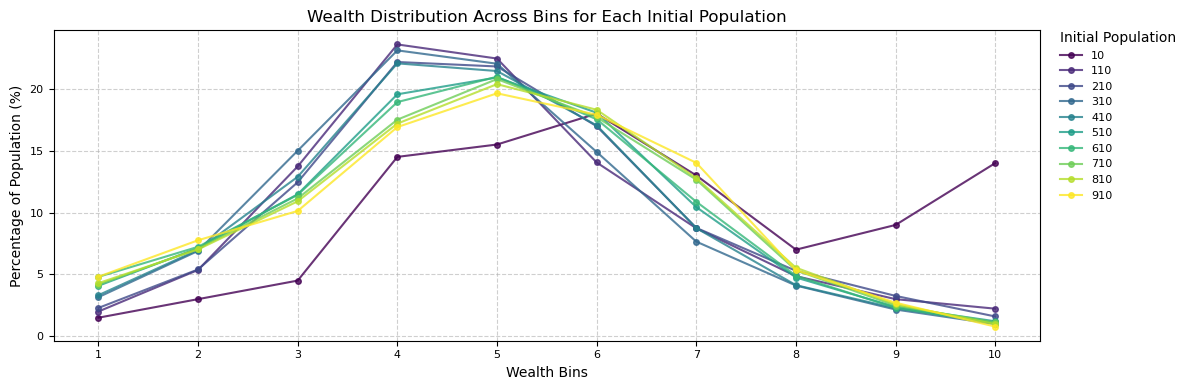

In [64]:
plt.figure(figsize=(12, 4))

# Generate colors from the 'viridis' palette
colors = cm.viridis(np.linspace(0, 1, len(unique_initial_population)))

# Plot each initial population with differentiated colors
for i, population in enumerate(unique_initial_population):
    subset = ss3_grouped_initpop[ss3_grouped_initpop['init_pop'] == population]
    plt.plot(range(1, 11), subset['sugar_histogram'].values[0], 
             marker='o', markersize=4, linestyle='-', linewidth=1.5, alpha=0.8, 
             color=colors[i], label=f'{population}')

# Improved labels and titles
plt.xlabel('Wealth Bins')
plt.ylabel('Percentage of Population (%)')
plt.title('Wealth Distribution Across Bins for Each Initial Population')

# Adjust axis ticks
plt.xticks(range(1, 11), fontsize=8)
plt.yticks(fontsize=8)
# Move the legend outside the plot for better clarity and align title and content to the left
plt.legend(title='Initial Population', title_fontsize=10, fontsize=8, bbox_to_anchor=(1.01, 1.03), loc='upper left', frameon=False,alignment='left')

#Edit graphics aesthetics
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


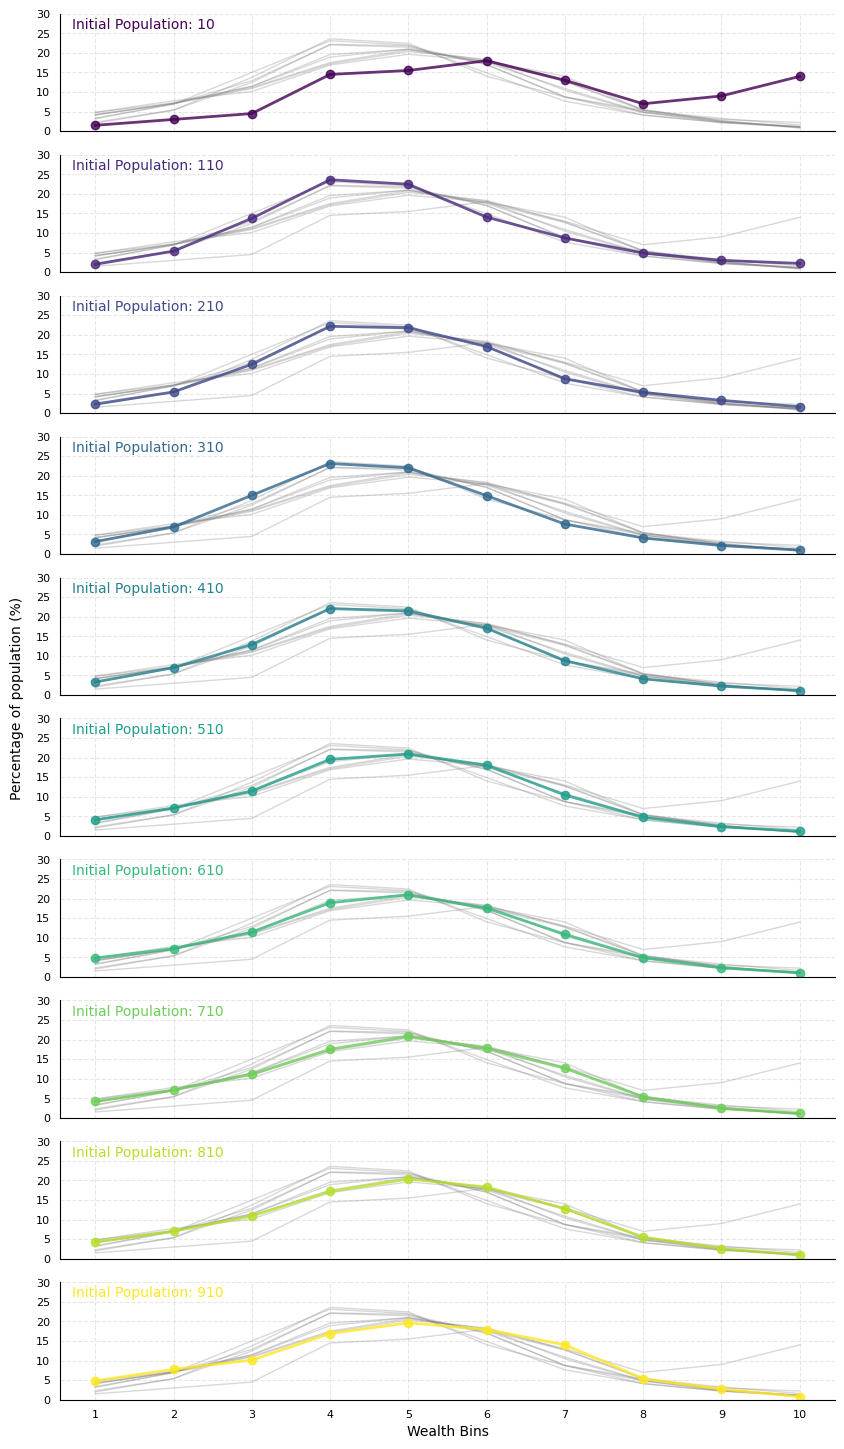

In [22]:
# Define the number of populations
num_populations = len(unique_initial_population)

# Create the figure with multiple stacked subplots
fig, axes = plt.subplots(num_populations, 1, figsize=(10, 1.8 * num_populations), sharex=True)

# Generate colors from the 'viridis' palette
colors = cm.viridis(np.linspace(0, 1, num_populations))

# Plot each distribution in a separate subplot
for i, (ax, pop, color) in enumerate(zip(axes, unique_initial_population, colors)):
    # Plot all other histograms in grey
    for other_pop in unique_initial_population:
        if other_pop != pop:
            other_subset = ss3_grouped_initpop[ss3_grouped_initpop['init_pop'] == other_pop]['sugar_histogram'].values[0]
            ax.plot(range(1, 11), other_subset, color='grey', alpha=0.3, linewidth=1)

    # Plot the histogram line for the current population
    subset = ss3_grouped_initpop[ss3_grouped_initpop['init_pop'] == pop]['sugar_histogram'].values[0]
    ax.plot(range(1, 11), subset, marker='o', linestyle='-', linewidth=2, color=color, alpha=0.8)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Remove Y-axis ticks for a cleaner design
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    # Set Y-axis label and limits
    ax.set_ylim(0, 30)

    # Place initial population text to the right of the plot
    ax.text(0.7, ax.get_ylim()[1] - 1, f'Initial Population: {pop}', fontsize=10, color=color, verticalalignment='top')

    # Add subtle grid to each subplot
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_yticks(np.arange(0, 31, 5))
    ax.set_xticks(np.arange(1, 11, 1))
    ax.tick_params(axis='both', labelsize=8)

# X-axis label (only in the last subplot)
axes[-1].set_xlabel('Wealth Bins', fontsize=10)

# Common Y-axis label
fig.text(0.075, 0.5, 'Percentage of population (%)', va='center', rotation='vertical', fontsize=10)

# Adjust space between subplots
plt.subplots_adjust(hspace=0.2)

plt.show()


#### Wealth distribution over time

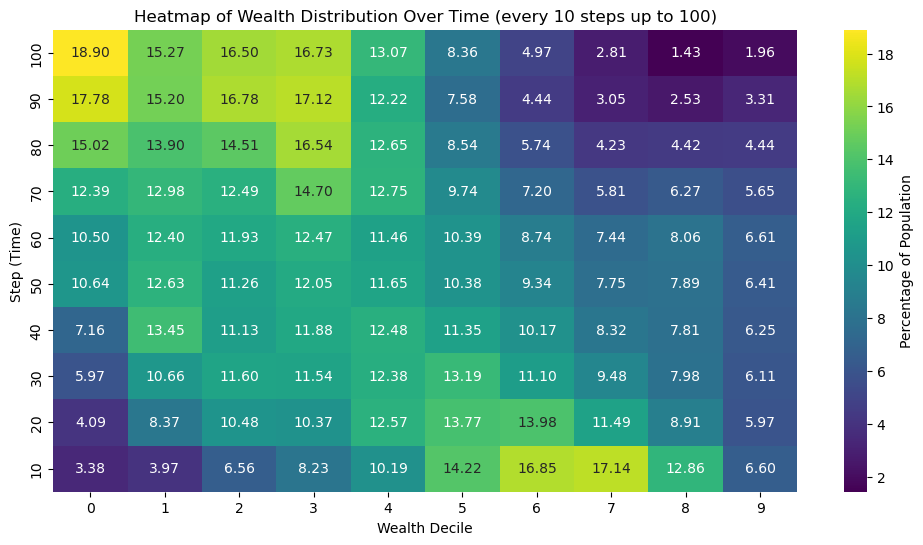

In [40]:
# Choose key steps to report in the heatmap. They will be steps that are multiples of 10 and less than or equal to 100
time_histogram_filter = time_histogram[(time_histogram.index % 10 == 0) & (time_histogram.index <= 100)& (time_histogram.index >= 1)]

# Plot the heatmap with annotations
plt.figure(figsize=(12, 6))
sns.heatmap(time_histogram_filter.iloc[::-1], cmap="viridis", cbar_kws={'label': 'Percentage of Population'}, annot=True, fmt=".2f")
plt.ylabel("Step (Time)")
plt.xlabel("Wealth Decile")
plt.title("Heatmap of Wealth Distribution Over Time (every 10 steps up to 100)")
plt.show()